# CNN Feature Importance and Model Tests

In this notebook I:

* Export the feature importance array from the best model
* Test the model on some "wild" data, i.e. not already coded
* Test the model on FOX data
* Examine some mis-classified sentences

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

Here I'm recreating the best model found in the performance tuning.

In [2]:
cnn_df = pd.read_excel('../data/interim/cnn_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
len(cnn_df)

10000

In [3]:
y = np.array(cnn_df['isad'])
X = cnn_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['thats why were working on ways to improve it',
 'theres no changing democrats got a benefit from an unusually large number of voters in  people who hadnt votds in  who turned up and voted predomitly for democrats',
 'otherwise we just wont be able to do business',
 ' she would move to canada if you got elected',
 'do you see it as an unrealistic position']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [8]:
X_train_bow = vect.fit_transform(corpus_train)
X_test_bow = vect.transform(corpus_test)
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_train_bow_df.columns = vect.get_feature_names()
X_train_bow_df.head()

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,$,$ away,$ billion,$ million,$ select,aarp,aarp medicare,abe,abe ha,ability,...,zero minimum,zip,zip code,zip lining,zone,zoo,¢,¢ xuv,„,„ ¢
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_train_joined = X_train.reset_index().join(X_train_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_bow_df.columns = vect.get_feature_names()
X_test_joined = X_test.reset_index().join(X_test_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])

In [10]:
X_train_joined = X_train_joined.drop(columns=['sentence_l', 'sentence_r'])
X_test_joined = X_test_joined.drop(columns=['sentence_l', 'sentence_r'])

In [11]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', random_state=18, n_estimators=100, 
                                      min_samples_split=2, max_features='sqrt', max_depth=200)
rfc.fit(X_train_joined, y_train)
score = rfc.score(X_test_joined, y_test)
print('RFC score is: {}'.format(score))

RFC score is: 0.86


Export feature importances:

In [ ]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train_joined.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.to_csv(r'../data/processed/cnn_feature_importances.csv')

In [33]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

[[2060   86]
 [ 334  520]]


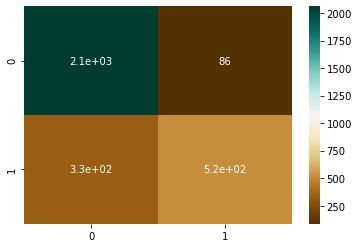

In [52]:
plot_confusion_matrix(rfc, X_test_joined, y_test)

In [53]:
pred = rfc.predict(X_test_joined)

In [54]:
pred_df = X_test.copy()
pred_df['predicted_ad'] = pred
pred_df['actual_ad'] = y_test
pred_df.head()

,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,topic_0,topic_1,topic_2,...,has_prev_ahead,has_prev_return,has_prev_after this,has_prev_go away,has_next_good evening,has_prev_applause,has_next_applause,has_prev_tuned,predicted_ad,actual_ad
367,2220,2280,you have to be able to read and know what your...,1,0,0,0,0.005524,0.005524,0.005524,...,0,0,0,0,0,0,0,0,0.0,0.0
5652,3180,3240,"is this a show that ""veep"" was made off of?",1,0,0,0,0.013333,0.013333,0.013333,...,0,0,0,0,0,0,0,0,0.0,0.0
8942,2580,2640,how can he forget his own words only weeks ago?,1,0,0,0,0.004930,0.004930,0.004930,...,0,0,0,0,0,0,0,0,0.0,0.0
5811,480,540,"i think, again, they have a responsibility in ...",1,0,0,0,0.005523,0.005523,0.005523,...,0,0,0,0,0,0,0,0,0.0,0.0
3890,240,300,does this further embolden president trump?,1,0,0,0,0.005762,0.005762,0.005762,...,0,0,0,0,0,0,0,0,0.0,0.0


View sentences thhat are false positives, i.e. falsely identified as ads.

In [55]:
for row in pred_df[(pred_df.predicted_ad == 1) & (pred_df.actual_ad == 0)]['sentence']:
    print(row)

we can show you that tweet.
i had the chance to sit down with the disney ceo bob iger.
he's not dipping into those pockets to help with the emergency need.
they can sell the treasuries they have amassed, which would be destabilizing to the economy.
this is really brazen contempt
miralax.
question for you, is four years of college still worth it?
us?
bring it on o, bring it on.
miralax works with the water in your body to unblock your system naturally.
obstruction.
of all the women we into to electability of any vemplial democratic challenger was top priority.
we like drip coffee, layovers- -and waiting on hold.
jerry has a membership to this gym, but he's not using it.
 max?
jennifer dulos was last heard from friday shortly after she dropped her children off at school.
bringing you more great tasting beverages with less sugar or no sugar at all.
now you can schedule a callback or reschedule an appointment, even on nights and weekends.
i'd rather not.
richer stories.
well, it's easy, he

View false negatives, i.e. sentences falsely marked as NOT being ads.

In [56]:
for row in pred_df[(pred_df.predicted_ad == 0) & (pred_df.actual_ad == 1)]['sentence']:
    print(row)

we needed a car that would last long enough to see it all.
and one that says, "i can."
with nine grams of protein and twenty-six vitamins and minerals.
or current gm owners can get twenty seven fifty total cash allowance on this traverse.
because, they really need their space.
today, life-changing technology from abbott is helping hunt them down at their source.
it has available led cargo area lighting.
and is the fastest growing place to buy a car in the nation.
[] check your credit scores for free
green things and brown things don't mix.
this part is up to you.
when i had my brother take me places, it was always like, we had to get there early so i could smoke a cigarette before we go inside.
me, me, me.
save hundreds of dollars a year when you get internet and mobile together.
it's complicated.
and his daughter, maria.
what if other kinds of plants captured it too?
for just $35 a month.
namaste?
the switch was easy.
so let's get after it.
vraylar treats acute mania of bipolar 1 diso

In this section, I run the model on a small additional set of wild data to see how it performs on data not in the training or testing set. See final report for a discussion of the results.

In [ ]:
extra_df = pd.read_csv('../data/interim/cnn_to_be_tested.csv')

In [59]:
extra_df = extra_df[10001:10301]
len(extra_df)

300

In [63]:
extra_fea = extra_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime']).dropna()
extra_bow = vect.transform(extra_fea['sentence'])

In [64]:
extra_bow_df = pd.DataFrame(extra_bow.toarray())
extra_bow_df.columns = vect.get_feature_names()
extra_joined = extra_fea.reset_index().join(extra_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])

In [65]:
extra_joined = extra_joined.drop(columns=['sentence_l', 'sentence_r'])

In [68]:
extra_joined = extra_joined.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [67]:
extra_joined.head()

,Unnamed: 0,Unnamed: 0.1,start_snip,end_snip,cluster,ad_cluster,news_cluster,snip_ad,topic_0,topic_1,...,zero minimum,zip,zip code,zip lining,zone,zoo,¢,¢ xuv,„,„ ¢
0,20001,20001,2460,2520,1,0,0,0,0.002758,0.002758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20002,20002,2520,2580,1,0,0,0,0.003902,0.003902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20003,20003,2520,2580,1,0,0,0,0.002134,0.466966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20004,20004,2520,2580,1,0,0,0,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20005,20005,2520,2580,1,0,0,0,0.006667,0.006667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
pred = rfc.predict(extra_joined)

In [70]:
extra_df['pred_ad'] = pred
extra_df.to_csv('../data/processed/cnn_wild_test.csv')

In this section, I test the CNN model on FOX sentences, and found it was surprisingly accurate. It will be interesting to see if the opposite is true.

In [21]:
fox_df = pd.read_excel('../data/interim/fox_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
len(fox_df)

10000

In [28]:
fox_df['sentence'] = fox_df['sentence'].astype('str')

In [29]:
fox_fea = fox_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'isad',
                                 'runtime'])
fox_bow = vect.transform(fox_fea['sentence'])
fox_bow_df = pd.DataFrame(fox_bow.toarray())
fox_bow_df.columns = vect.get_feature_names()
fox_joined = fox_fea.reset_index().join(fox_bow_df, lsuffix='_l', rsuffix='_r').drop(columns=['index'])
fox_joined = fox_joined.drop(columns=['sentence_l', 'sentence_r'])

In [30]:
fox_true = fox_df['isad']

In [31]:
print("Accuracy of CNN model on FOX: {}".format(rfc.score(fox_joined, fox_true)))

Accuracy of CNN model on FOX: 0.8771


[[8137  301]
 [ 928  634]]


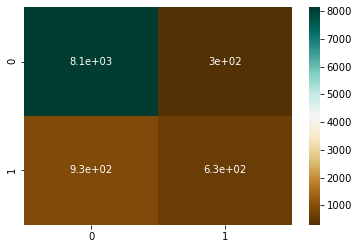

In [34]:
plot_confusion_matrix(rfc, fox_joined, fox_true)